# (MIDI) Prédiction et génération de fichier midi

Ce programme s'appuie sur les travaux de Mantas Lukoševičius pour proposer une génération de fichier MIDI depuis une base de morceaux.

In [1]:
%matplotlib inline
import mido
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from ipywidgets import *
from IPython.display import *

In [2]:
def set_seed(seed=None):
    """Making the seed (for random values) variable if None"""

    if seed is None:
        import time
        seed = int((time.time()*10**6) % 4294967295)
        print(seed)
    try:
        np.random.seed(seed)
        print("Seed used for random values:", seed)
    except:
        print("!!! WARNING !!!: Seed was not set correctly.")
    return seed

class Network(object):

    def __init__(self, trainLen=2000, testLen=2000, initLen=100) :
        self.initLen = initLen
        self.trainLen = trainLen
        self.testLen = testLen
        self.file = open("extrait_bach.txt", "r")
        self.resSize = 300
        self.a = 0.3
        self.spectral_radius = 1.25
        self.input_scaling = 1.
        self.reg =  1e-8
        self.mode = 'prediction'
        seed = None #42
        set_seed(seed)
        
nw = Network()

1280898091
Seed used for random values: 1280898091


Lecture d'un fichier avec juste les notes et mise dans une liste

The next function analyzes a text (e.g., Sir Arthur Conan Doyle's Sherlock Holmes), and returns a list containing all the different characters that are present in the text. You can choose between taking case, punctuation and/or numbers into account.

In [3]:
def filter_characters(nw, file_name) :
    nw.input_text=[]
    nw.file = open(file_name, 'r')
    for i in nw.file:
        nw.input_text.append(i[:2])

    return(nw)

Let's see what characters are in the chosen input text.

In [4]:
def characters(nw) :
    nw.input_units, nw.output_units = dict(), dict()
    for i, item in enumerate(set(nw.input_text)) : nw.input_units[item] = i
    for i, item in enumerate(set(nw.input_text)) : nw.output_units[i] = item
    #nw.input_units = dict(enumerate(set(nw.input_text)))
    print("\nExisting notes in the midi file :", sorted(nw.input_units),
          "\nNumber of different notes :", len(nw.input_units), "\n")
    return(nw)

We will then convert the text values into numerical values, usable by the algorithm. We will consider the input as a vector $u(t)$, where each line matches a different character, according to <b>nw.chars</b>. Since there only can be one character at a time, we will convert the text from nw.input_text into a nw.data vector, where each element will be a character ID according to its position in nw.chars.

In [5]:
def convert_input(nw) :
    print("Converting input into ID numbers...", end=" ")
    nw.data = np.array([nw.input_units[i] for i in nw.input_text])
    print(len(nw.input_units))
    print(len(nw.input_text))
    nw.inSize = nw.outSize = len(nw.input_units)
    print("done.")
    return(nw)

Now, we can try this on our network. The input $u$ will now be a vector, matching the size of nw.chars. Every time the program "reads" a character, we will give the corresponding neuron a value of 1. In any other case, this value will be 0.

In [6]:
def binary_data(nw) :
    print("Creating the input binary matrix...", end=" ")
    nw.data_b = np.zeros((len(nw.input_text), len(nw.input_units)))
    print(nw.data.shape)
    for i, item in enumerate(nw.data) :
        nw.data_b[i][item] = 1
    print("done.\n") 
    return(nw)

Then, we copy the code from the ESN.

In [7]:
def initialization(nw) :
    print("\nInitializing the network matrices...", end=" ")
    set_seed()
    nw.Win = (np.random.rand(nw.resSize,1+nw.inSize)-0.5) * nw.input_scaling
    nw.W = np.random.rand(nw.resSize,nw.resSize)-0.5 
    nw.X = np.zeros((1+nw.inSize+nw.resSize,nw.trainLen-nw.initLen))
    nw.Ytarget = nw.data_b[nw.initLen+1:nw.trainLen+1].T
    print(nw.data_b.shape)
    print(nw.X.shape)
    print(nw.Ytarget.shape)
    print(nw.data_b[nw.initLen+1:nw.trainLen+1].T)
    nw.x = np.zeros((nw.resSize,1))
    print("done.")
    return(nw)

def compute_spectral_radius(nw):
    print('Computing spectral radius...',end=" ")
    rhoW = max(abs(linalg.eig(nw.W)[0]))
    print('done.')
    nw.W *= nw.spectral_radius / rhoW
    return(nw)

def train_network(nw) :
    print('Training the network...', end=" ")
    percent = 0.1
    for t in range(nw.trainLen):
        percent = progression(percent, t, nw.trainLen)
        nw.u = nw.data_b[t%len(nw.data)]
        nw.x = (1-nw.a)*nw.x + nw.a*np.tanh( np.dot(nw.Win, np.concatenate((np.array([1]),nw.u)).reshape(len(nw.input_units)+1,1) ) + np.dot( nw.W, nw.x ) )
        if t >= nw.initLen :
            nw.X[:,t-nw.initLen] = np.concatenate((np.array([1]),nw.u,nw.x[:,0])).reshape(len(nw.input_units)+nw.resSize+1,1)[:,0]      
    print('done.')
    return(nw)

def train_output(nw) :
    print('Training the output...', end=" ")
    nw.X_T = nw.X.T
    print(nw.Ytarget.shape)
    print(nw.X_T.shape)
    print(nw.X.shape)
    print(nw.data.shape)
    print(nw.data)
    print(nw.data_b.shape)
    print(nw.data_b)
    if nw.reg is not None:
        nw.Wout = np.dot(np.dot(nw.Ytarget,nw.X_T), linalg.inv(np.dot(nw.X,nw.X_T) + nw.reg*np.eye(1+nw.inSize+nw.resSize) ) )
    else:
        nw.Wout = np.dot(nw.Ytarget, linalg.pinv(nw.X) )   
    print('done.')
    return(nw)

def test(nw) :
    print('Testing the network... (', nw.mode, ' mode)', sep="", end=" ")
    nw.Y = np.zeros((nw.outSize,nw.testLen))
    nw.u = nw.data_b[nw.trainLen%len(nw.data)]
    percent = 0.1
    for t in range(nw.testLen):
        percent = progression(percent, t, nw.trainLen)
        nw.x = (1-nw.a)*nw.x + nw.a*np.tanh( np.dot(nw.Win, np.concatenate((np.array([1]),nw.u)).reshape(len(nw.input_units)+1,1)\
                                                   ) + np.dot(nw.W,nw.x ) )
        nw.y = np.dot(nw.Wout, np.concatenate((np.array([1]),nw.u,nw.x[:,0])).reshape(len(nw.input_units)+nw.resSize+1,1)[:,0] )
        nw.Y[:,t] = nw.y
        if nw.mode == 'generative':
            # generative mode:
            nw.u = nw.y
        elif nw.mode == 'prediction':
            ## predictive mode:
            nw.u = np.zeros(len(nw.input_units))
            nw.u[nw.data[(nw.trainLen+t+1)%len(nw.data)]] = 1
        else:
            raise(Exception, "ERROR: 'mode' was not set correctly.")
    print('done.\n')
    return(nw)

def compute_error(nw) :
    print("Computing the error...", end=" ")
    errorLen = 5
    mse = sum( np.square( nw.data[(nw.trainLen+1)%len(nw.data):(nw.trainLen+errorLen+1)%len(nw.data)] - nw.Y[0,0:errorLen] ) ) / errorLen
    print('MSE = ' + str( mse ))
    return(nw)

When the output is ready, it's only characters IDs. The next function will "translate" those ID into the corresponding characters.

In [8]:
def convert_output(nw) :
    nw.output_text = ""
    nw.output_values = []
    print("Converting the output...", end=" ")
    for i in range(len(nw.Y.T)) :
        value = nw.output_units[nw.Y.T[i].argmax()]
        nw.output_text += value + " "
        if(value != ''):
            nw.output_values.append(int(value))
    print("done.")
    return(nw.output_text)
    
def progression(percent, i, total) :
    if i == 0 :
        print("Progress :", end= " ")
        percent = 0.1
    elif (i/total) > percent :
        print(round(percent*100), end="")
        print("%", end=" ")
        percent += 0.1
    if total-i == 1 :
        print("100%")
    return(percent)

def compute_network(nw, file_name) :
    nw = filter_characters(nw, file_name)
    nw = characters(nw)
    nw = convert_input(nw)
    nw = binary_data(nw)
    nw = initialization(nw)
    nw = compute_spectral_radius(nw)
    nw = train_network(nw)
    nw = train_output(nw)
    nw = test(nw) 
    nw = compute_error(nw)
    nw = convert_output(nw)
    return(nw)

## Configure network

Let's configure the network's variables you want to use.

In [9]:
select_mode = ToggleButtons(description='Mode:', options=['prediction', 'generative'])
text = Dropdown(description='Fichier Midi:', options={"House of the rising sun" : 1, "Bach" : 2}, value = 2)
var4 = FloatSlider(value=300, min=0, max=5000, step=1, description='resSize')
var5 = FloatText(value=20, description='initLen')
var6 = FloatText(value=1000, description='trainLen')
var7 = FloatText(value=1000, description='testLen')
var8 = FloatSlider(value=1.25, min=0, max=10, step=0.05, description='spectral radius')
var9 = FloatSlider(value=0.3, min=0, max=1, step=0.01, description='leak rate')
valid = Button(description='Validate')

NOTES_FILE_NAME = "notes.txt"
SPEEDS_FILE_NAME = "speeds.txt"
    
notes_values = []
speeds_values = []

def midi_to_txt(name):    
    mid = mido.MidiFile("samples/" + name)
    
    notes = []
    sumTime = 0

    for msg in mid:
        sumTime += msg.time

        if(msg.type == "note_off" or (msg.type == "note_on" and msg.velocity == 0)):
            j = len(notes) - 1
            while(j >= 0):
                note, time = notes[j]
                if(note == msg.note):
                    notes[j] = (note, sumTime - time)
                    break
                j -= 1

        elif(msg.type == "note_on"):
            notes.append((msg.note, sumTime))
    
    notes_array = []
    speed_array = []
    for note, speed in notes:
        notes_array.append(note)
        speed_array.append(speed)
        
        
    notes_file = open(NOTES_FILE_NAME, "w")
    speeds_file = open(SPEEDS_FILE_NAME, "w")
    for note, speed in notes:
        notes_file.write(str(note)+"\n")
        speeds_file.write(str(speed*500)+"\n")
    
    notes_file.close()
    speeds_file.close()
    
    return NOTES_FILE_NAME, SPEEDS_FILE_NAME
    
    
def record_values(_):
    global notes_values
    global speeds_values
    
    file = text.value
    midis = ["house_of_the_rising_sunasax_as.mid", "bach_846_format0.mid"]
    notes_file_name, speeds_file_name = midi_to_txt(midis[file-1])
    
    #Notes network
    print("### NOTES NETWORK ###")
    #clear_output()
    nw.mode=select_mode.value
    nw.resSize=int(var4.value)
    nw.initLen=int(var5.value)
    nw.trainLen=int(var6.value)
    nw.testLen=int(var7.value)
    nw.spectral_radius=float(var8.value)
    nw.a=float(var9.value)
    
    print("InitLen:", nw.initLen, "TrainLen:", nw.trainLen, "TestLen:", nw.testLen) 
    print("ResSize:", nw.resSize, "Spectral Radius:", nw.spectral_radius, "Leak Rate:", nw.a)
        
    compute_network(nw, notes_file_name)
    notes_values = nw.output_values
    
    #Speeds network
    print("### SPEEDS NETWORK ###")
    #clear_output()
    nw.mode=select_mode.value
    nw.resSize=int(var4.value)
    nw.initLen=int(var5.value)
    nw.trainLen=int(var6.value)
    nw.testLen=int(var7.value)
    nw.spectral_radius=float(var8.value)
    nw.a=float(var9.value)
    
    print("InitLen:", nw.initLen, "TrainLen:", nw.trainLen, "TestLen:", nw.testLen) 
    print("ResSize:", nw.resSize, "Spectral Radius:", nw.spectral_radius, "Leak Rate:", nw.a)
        
    compute_network(nw, speeds_file_name)
    speeds_values = nw.output_values
    
    print("Notes predicted : ")
    print(notes_values)
    print("Speeds predicted : ")
    print(speeds_values)
    

display(select_mode)
display(text)
display(var4)
display(var5)
display(var6)
display(var7)
display(var8)
display(var9)
display(valid)

valid.on_click(record_values)

ToggleButtons(description='Mode:', options=('prediction', 'generative'), value='prediction')

Dropdown(description='Fichier Midi:', index=1, options={'House of the rising sun': 1, 'Bach': 2}, value=2)

FloatSlider(value=300.0, description='resSize', max=5000.0, step=1.0)

FloatText(value=20.0, description='initLen')

FloatText(value=1000.0, description='trainLen')

FloatText(value=1000.0, description='testLen')

FloatSlider(value=1.25, description='spectral radius', max=10.0, step=0.05)

FloatSlider(value=0.3, description='leak rate', max=1.0, step=0.01)

Button(description='Validate', style=ButtonStyle())

### NOTES NETWORK ###
InitLen: 20 TrainLen: 1000 TestLen: 1000
ResSize: 300 Spectral Radius: 1.25 Leak Rate: 0.3

Existing notes in the midi file : ['36', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '76', '77', '78', '79', '81', '82', '83', '84'] 
Number of different notes : 44 

Converting input into ID numbers... 44
1284
done.
Creating the input binary matrix... (1284,)
done.


Initializing the network matrices... 1298607779
Seed used for random values: 1298607779
(1284, 44)
(345, 980)
(44, 980)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
done.
Computing spectral radius... done.
Training the network... Progress : 10% 20% 30% 40% 50% 60% 70% 80% 90% 100%
done.
Training the output... (44, 980)
(980, 345)
(345, 98

The next graph shows the characters repartition throughout the first characters of the text. The x-axis represents the first n characters of the text (which you can change), and the y-axis represents every different character in the text (generally ~70, counting upper case, lower case, numbers and punctuation symbols)..

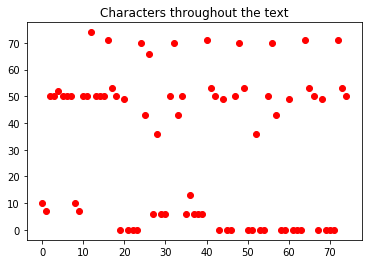

In [10]:
var10 = FloatText(value=len(nw.input_units), description='Number of chars')
#La value de var10 ne peut pas dépasser le nombre de notes présentes dans le fichier midi  
valid2 = Button(description='Validate')
        
def trace_graph1(_) :
    clear_output()
    plt.figure(1).clear()
    limit = np.arange(int(var10.value))
    plt.plot(limit,nw.data[0:int(var10.value)], 'ro')
    plt.title('Characters throughout the text')
    
valid2.on_click(trace_graph1)
    
display(var10)
display(valid2)

Finally, let's see the ouput text the program generates !

In [11]:
valid3 = Button(description='Show the output!')

def show_output(_) :
    print(nw.output_text)

display(valid3)
valid3.on_click(show_output)

Button(description='Show the output!', style=ButtonStyle())

23 23 23 10 10 10 10 10 23 23 23 23 23 23 23 23 23 23 35 11 22 22 22 22 22 11 11 11 11 11 11 11 10 10 10 10 10 10 23 23 23 23 23 10 10 23 23 23 10 10 10 10 35 35 99 99 99 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 11 11 23 23 23 23 23 23 35 11 11 11 11 11 11 35 35 23 23 10 10 10 10 10 10 10 10 10 10 86 86 86 11 11 11 35 23 23 78 23 78 78 78 86 22 22 22 22 22 22 22 22 23 23 23 47 23 23 47 52 23 23 23 23 97 23 23 23 23 23 23 23 23 23 35 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 86 35 35 35 35 35 99 23 23 11 11 23 97 23 23 79 23 23 79 23 23 23 23 96 96 96 12 96 96 90 90 96 90 90 90 90 90 12 12 11 11 90 11 11 98 11 11 12 80 12 12 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 10 23 23 23 23 23 99 99 99 10 99 99 21 21 21 21 21 21 10 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 21 21 21 21 21 12 12 12 12 12 12 98 98 98 98 98 80 68 99 99 87 98 97 35 78 68 99 88 88 97 97 97 79 69 10 23 88 88 97 10 78 68 9

In [50]:
from mido import Message, MidiFile, MidiTrack

mid = MidiFile()
track = MidiTrack()
mid.tracks.append(track)

for i in range(len(notes_values)):
    #print("note : " + str(notes_values[i]) + " speed : " + str(speeds_values[i]))
    track.append(Message('note_on', note=notes_values[i], time=0))
    track.append(Message('note_off', note=notes_values[i], time=speeds_values[i]*7))

mid.save('new_song.mid')